# 深度学习基础3_模型选择、欠拟合和过拟合      

- **训练误差**:指模型在训练数据集上表现出的误差.

- **泛化误差**：指模型在**任意一个测试数据样本**上表现出的误差的期望，并常常通过**测试数据集上的误差来近似**。


在机器学习里，通常假设训练数据集（训练题）和测试数据集（测试题）里的每一个样本都是从**同一个概率分布中相互独立地生成的**。基于该独立同分布假设，给定任意一个机器学习模型（含参数），它的**训练误差的期望和泛化误差都是一样的**。

- **机器学习模型应关注降低泛化误差。**

## 模型选择
- **模型选择（model selection）**：评估若干候选模型的表现并从中选择模型。

&emsp;&emsp;可供选择的候选模型可以是有着**不同超参数的同类模型**。


## 验证数据集

从严格意义上讲，测试集只能在**所有超参数和模型参数选定后使用一次**。

- 预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为**验证数据集，简称验证集（validation set）**。


## K折交叉验证

由于验证数据集不参与模型训练，当训练数据不够用时，预留大量的验证数据不可行。       

一种改善的方法是**K折交叉验证（K-fold cross-validation）**。            
在K折交叉验证中，把原始训练数据集分割成K个不重合的子数据集，做K次模型训练和验证。          

每一次，我们使用**一个子数据集验证模型**，并使用其他**K−1个子数据集来训练模型**。最后，我们对这K次训练误差和验证误差**求平均**。

## 欠拟合和过拟合


**欠拟合（underfitting）**:一类是模型无法得到较低的训练误差.

**过拟合（overfitting）**:另一类是模型的训练误差远小于它在测试数据集上的误差

- **影响拟合程度因素**：     

1. 模型复杂程度      
&emsp;&emsp;因为高阶多项式函数模型参数更多，模型函数的选择空间更大，所以高阶多项式函数比低阶多项式函数的复杂度更高。如果模型的复杂度过低，很容易出现欠拟合；如果模型复杂度过高，很容易出现过拟合。


2. 训练数据集大小         
&emsp;&emsp;如果训练数据集中样本数过少，特别是比模型参数数量（按元素计）更少时，过拟合更容易发生。

In [1]:
# 多项式函数拟合实验
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
features[:2], poly_features[:2], labels[:2]

(tensor([[-0.1167],
         [ 0.2725]]),
 tensor([[-0.1167,  0.0136, -0.0016],
         [ 0.2725,  0.0743,  0.0202]]),
 tensor([4.7984, 5.1752]))

In [2]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)

final epoch: train loss 9.128348756348714e-05 test loss 8.988712215796113e-05
weight: tensor([[ 1.1992, -3.3988,  5.6005]]) 
bias: tensor([4.9986])


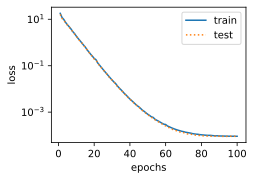

In [3]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

final epoch: train loss 125.58941650390625 test loss 121.8359146118164
weight: tensor([[17.7467]]) 
bias: tensor([2.5169])


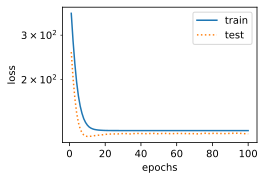

In [4]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

final epoch: train loss 0.4807003438472748 test loss 249.1356658935547
weight: tensor([[0.8022, 0.6425, 0.5514]]) 
bias: tensor([4.1976])


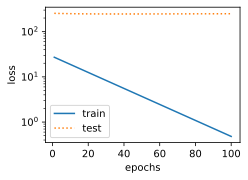

In [5]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])